In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [2]:
# Main function you call from the other script
# Note that you have to tell the other notebook that it should use this notebook, something with % blabla AnalyseFootScan.ipynb
# In case you run it with all pictures better comment the plots...
def analyseFootScan(image, do_visualization):

    # convert to RGB 
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Note: By default OpenCV used BGR

    # convert to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # visualization of color image and gray-scale
    if do_visualization:
        print('Visualization of foot scan in RGB and grayscale:')
        fig1 = plt.figure(1)
        plt.subplot(121)
        plt.imshow(img_rgb)
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.subplot(122)
        plt.imshow(img_gray, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.show()
    
    # extract foot region from grayscale image
    # alternatively one could use a separated channel, i.e. red, green or blue
    foot_region = extractFootRegion(img_gray, do_visualization)
    
    # clean grayscale image using extracted foot region
    img_gray_clean = img_gray.copy()
    # get image dimensions
    w = img_gray_clean.shape[1] 
    h = img_gray_clean.shape[0]
    for y in range(0, h): # loop over image
        for x in range(0, w):
            if foot_region[y, x] == 0:
                img_gray_clean[y, x] = 255

    # visualization of clean grayscale image
    if do_visualization:
        print('Visualization of cleaned grayscale:')
        fig1 = plt.figure(1)
        plt.subplot(111)
        plt.imshow(img_gray_clean, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.show()

    # extract foot dimensions
    length_cm, length_dots, width_cm, width_dots = extractFootDimensions(img_gray_clean, do_visualization)
    
    return length_cm, length_dots, width_cm, width_dots

In [3]:
def extractFootRegion(img_gray, do_visualization):
    
    # get binary image via threshold
    ret,img_binary = cv2.threshold(img_gray,245,255,0)
    img_binary = cv2.bitwise_not(img_binary) # to have the foot region white and the background black

    # remove artifacts by opening and closing
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(20,20))
    img_clean = cv2.morphologyEx(img_binary, cv2.MORPH_OPEN, element)
    img_clean = cv2.morphologyEx(img_clean, cv2.MORPH_CLOSE, element)
    
    # if multiple objects only keep largest object
    # get contours in binary image
    img_contours = img_clean.copy() # required since contour function modifies image
    some_img, contours, hierarchy = cv2.findContours(img_contours,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img_contours,contours,-1,(150,0,0),3) # for visualization
    # check number of objects
    if (len(contours) > 1): 
        print('Warning: There is more than one object in the image!')
        # find index of largest object
        max_idx = 0
        for i in range(1,len(contours)):
            if len(contours[i]) > len(contours[max_idx]):
                max_idx = i
        # delete all objects but the largest one
        for i in range(0,len(contours)):
            if i != max_idx:
                cv2.fillPoly(img_clean, pts =[contours[i]], color=(0,0,0))
    
    # removed artifacts 
    # Note: Just for visualization, opening deletes some pixels and closing adds pixels
    img_artifacts_removed = img_binary - img_clean
    img_artifacts_added = img_clean - img_binary

    if do_visualization:
        print('Visualization of artifact removal and resulting over-approximative foot region:')
        
        fig1 = plt.figure(1)
        plt.subplot(151)
        plt.imshow(img_binary, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.subplot(152)
        plt.imshow(img_contours, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.subplot(153)
        plt.imshow(img_clean, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.subplot(154)
        plt.imshow(img_artifacts_removed, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.subplot(155)
        plt.imshow(img_artifacts_added, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.show()

    return img_clean

In [4]:
# Note: By now also toes are considered for width! 
def extractFootDimensions(img_gray_clean, do_visualization):
    
    # get image dimensions
    w = img_gray_clean.shape[1] 
    h = img_gray_clean.shape[0]
    
    ret,img_tresh = cv2.threshold(img_gray_clean,245,255,0)
    img_tresh = cv2.bitwise_not(img_tresh)
    
    # visualization of binary image of foot region based on threshold
    if do_visualization:
        print('Visualization of considered foot region for extraxting dimensions:')
        fig1 = plt.figure(1)
        plt.subplot(111)
        plt.imshow(img_tresh, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.show()
    
    row_sum = np.sum(img_tresh, axis=1)
    column_sum = np.sum(img_tresh, axis=0)

    upper_limit = -1
    for y in range(0, h): # loop over image columns
        if row_sum[y] > 0:
            upper_limit = y
            #print(upper_limit)
            break

    lower_limit = -1
    for y in range(h-1,-1,-1):
        if row_sum[y] > 0:
            lower_limit = y
            #print(lower_limit)
            break

    left_limit = -1
    for x in range(0,w):
        if column_sum[x] > 0:
            left_limit = x
            #print(left_limit)
            break

    right_limit = -1
    for x in range(w-1,-1,-1):
        if column_sum[x] > 0:
            right_limit = x
            #print(right_limit)
            break

    foot_length_dots = lower_limit - upper_limit + 1
    foot_length_inch = foot_length_dots/72.0
    foot_length_cm = foot_length_inch * 2.54

    foot_width_dots = right_limit - left_limit + 1
    foot_width_inch = foot_width_dots/72.0
    foot_width_cm = foot_width_inch * 2.54

    print("Foot length is " + str(round(foot_length_cm,2)) + " cm.")
    print("Foot width is " + str(round(foot_width_cm,2)) + " cm.")
    
    # Todo: move this somewhere else i.e. restructure
    # extract toes line
    polyline = extractToesLine(img_gray_clean, lower_limit, upper_limit, left_limit, right_limit, do_visualization)
    
    return round(foot_length_cm,2),round(foot_length_dots,2), round(foot_width_cm,2), round(foot_width_dots,2)

In [5]:
def extractToesLine(img_gray_clean, lower_limit, upper_limit, left_limit, right_limit, do_visualization):
    
    # use gaussian filter as pre-processing step
    img_blurr = cv2.GaussianBlur(img_gray_clean,(9,9),0)
    
    peaks = []
    
    current_position = int(0.5*(upper_limit+lower_limit))+1 # initialize peak position for last processed row
    for x in range(left_limit,right_limit+1,50): # for each fow in foot region
        
        # extract signal 1D-signal
        # Note: Extracted signal goes from x pixels (here 25) lower that the current peak position to the top of the foot region i.e. the upper limit
        signal = img_gray_clean[upper_limit:current_position,x] 
        signal = 1 - np.flip(signal/255.0,0) # invert that dark pixels are maxima and read from heel to toes
        
        signal_mean = np.mean(signal)*np.ones(len(signal))
        
        if do_visualization:
            img_gray_clean_copy = img_gray_clean.copy()
            img_gray_clean_copy[upper_limit:current_position,x-2:x+2] = 0
            
            fig1 = plt.figure(1)
            plt.subplot(111)
            plt.imshow(img_gray_clean_copy, cmap = 'gray')
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
            plt.show()
            
            fig2 = plt.figure(2)
            plt.plot(signal)
            plt.plot(signal_mean, 'r')
            plt.show()
        
        # detect peak in row
        # Todo
        peak_position = current_position - np.argmax(signal) # Somehow take first sharp peak in signal. Right now this takes global makima.
        
        # store extracted peak position for polyfit
        peaks.append(current_position)
        
        # update current peak position
        current_position = peak_position
        
    # fit polynom to peak positions
    # Todo
    

Visualization of foot scan in RGB and grayscale:


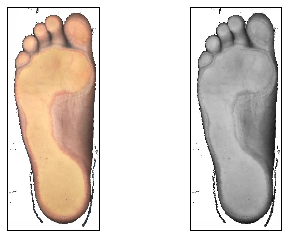

Visualization of artifact removal and resulting over-approximative foot region:


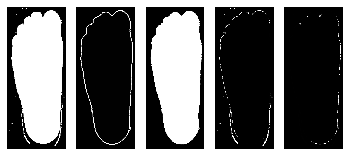

Visualization of cleaned grayscale:


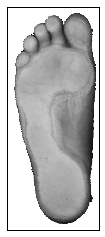

Visualization of considered foot region for extraxting dimensions:


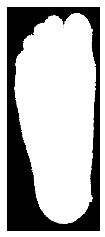

Foot length is 27.76 cm.
Foot width is 10.65 cm.


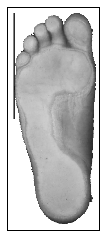

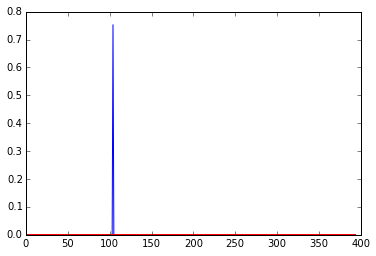

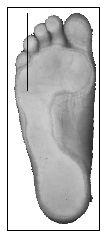

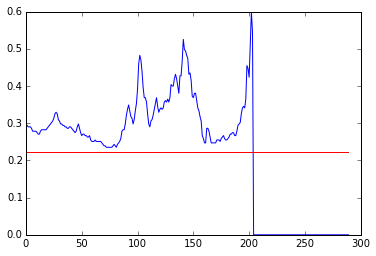

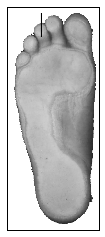

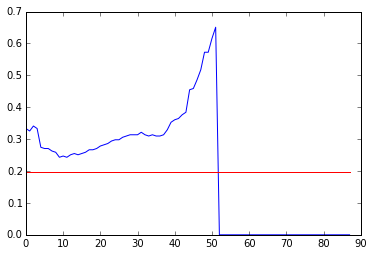

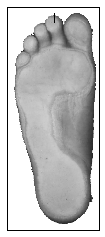

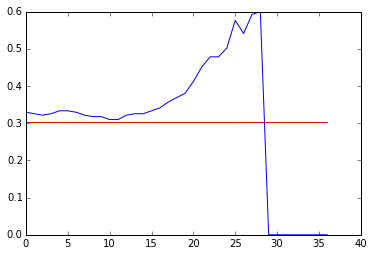

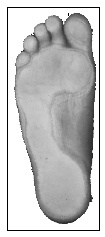

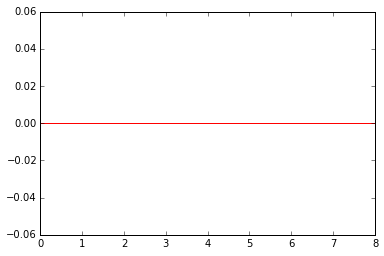

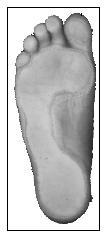

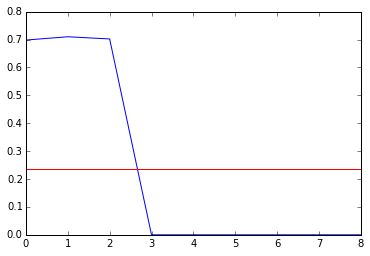

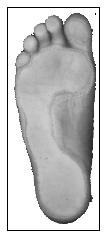

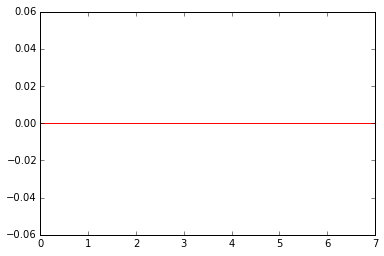

In [6]:
# This is the call that is added in the other notebook:

image = cv2.imread("Test2.JPG") # load image
length_cm, length_dots, width_cm, width_dots = analyseFootScan(image, True)